This notebook is an example of how to optimise samples for the SmartROI and WeightedDEW methods as done in the paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import sys
sys.path.append('../..')

In [4]:
import os

import numpy as np
import pylab as plt

In [5]:
from vimms.Common import download_file, extract_zip_file, save_obj, load_obj, POSITIVE, set_log_level_debug, set_log_level_warning
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiParams
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, WeightedDEWController, TopN_SmartRoiController
from vimms.Environment import Environment

from mass_spec_utils.data_processing.mzmine import pick_peaks
from mass_spec_utils.data_import.mzmine import load_picked_boxes, map_boxes_to_scans
from mass_spec_utils.data_import.mzml import MZMLFile

# Load files needed to run experiments

Get original mzml files that the methods were optimised on in the paper

In [6]:
url = 'https://github.com/glasgowcompbio/vimms-data/raw/main/model_optimisation.zip'
out_file = download_file(url)
extract_zip_file(out_file)

2022-02-23 10:40:21.828 | INFO     | vimms.Common:download_file:453 - Downloading model_optimisation.zip


  0%|          | 0.00/21.1k [00:00<?, ?KB/s]

2022-02-23 10:40:22.858 | INFO     | vimms.Common:extract_zip_file:466 - Extracting model_optimisation.zip


  0%|          | 0/17 [00:00<?, ?it/s]

2022-02-23 10:40:23.435 | INFO     | vimms.Common:extract_zip_file:473 - Deleting model_optimisation.zip


We can convert them into the ViMMS chemicals to allow us to run the virtual MS

In [7]:
SmartROI_QCA_mzml = os.path.abspath(os.path.join('model_optimisation', 'SmartROI', 'from_controller_TopN_QCA.mzML'))
SmartROI_QCB_mzml = os.path.abspath(os.path.join('model_optimisation', 'SmartROI', 'from_controller_TopN_QCB.mzML'))
WeightedDEW_QCA_mzml = os.path.abspath(os.path.join('model_optimisation', 'WeightedDEW', 'TopN_QCA.mzML'))
WeightedDEW_QCB_mzml = os.path.abspath(os.path.join('model_optimisation', 'WeightedDEW', 'TopN_QCB.mzML'))

The min_intensity value is set pretty high here to reduce input chemicals and let the notebook runs quick
For more accurate simulation, please lower it

In [8]:
# rp = RoiParams(mz_tol=5, min_length=1, min_intensity=0)
rp = RoiParams(mz_tol=5, min_length=1, min_intensity=5000)

In [9]:
ionisation_mode = POSITIVE

cm = ChemicalMixtureFromMZML(SmartROI_QCA_mzml, roi_params=rp)
SmartROI_QCA_dataset = cm.sample(None, 2, source_polarity=ionisation_mode)

cm = ChemicalMixtureFromMZML(SmartROI_QCB_mzml, roi_params=rp)
SmartROI_QCB_dataset = cm.sample(None, 2, source_polarity=ionisation_mode)

cm = ChemicalMixtureFromMZML(WeightedDEW_QCA_mzml, roi_params=rp)
WeightedDEW_QCA_dataset = cm.sample(None, 2, source_polarity=ionisation_mode)

cm = ChemicalMixtureFromMZML(WeightedDEW_QCB_mzml, roi_params=rp)
WeightedDEW_QCB_dataset = cm.sample(None, 2, source_polarity=ionisation_mode)

2022-02-23 10:40:31.256 | DEBUG    | vimms.Chemicals:_extract_rois:458 - Extracted 22672 good ROIs from /Users/joewandy/Work/git/vimms/examples/02. DDA Strategies (Davies et al 2020)/model_optimisation/SmartROI/from_controller_TopN_QCA.mzML
2022-02-23 10:40:43.795 | DEBUG    | vimms.Chemicals:_extract_rois:458 - Extracted 31731 good ROIs from /Users/joewandy/Work/git/vimms/examples/02. DDA Strategies (Davies et al 2020)/model_optimisation/SmartROI/from_controller_TopN_QCB.mzML
2022-02-23 10:40:51.107 | DEBUG    | vimms.Chemicals:_extract_rois:458 - Extracted 6197 good ROIs from /Users/joewandy/Work/git/vimms/examples/02. DDA Strategies (Davies et al 2020)/model_optimisation/WeightedDEW/TopN_QCA.mzML
2022-02-23 10:40:58.115 | DEBUG    | vimms.Chemicals:_extract_rois:458 - Extracted 23061 good ROIs from /Users/joewandy/Work/git/vimms/examples/02. DDA Strategies (Davies et al 2020)/model_optimisation/WeightedDEW/TopN_QCB.mzML


Save the chemical sets for future use (so we don't need to regenerate them again later)

In [10]:
save_obj(SmartROI_QCA_dataset, 'SmartROI_QCA_dataset.p')
save_obj(SmartROI_QCB_dataset, 'SmartROI_QCB_dataset.p')
save_obj(WeightedDEW_QCA_dataset, 'WeightedDEW_QCA_dataset.p')
save_obj(WeightedDEW_QCB_dataset, 'WeightedDEW_QCB_dataset.p')

2022-02-23 10:41:09.058 | INFO     | vimms.Common:save_obj:329 - Saving <class 'list'> to SmartROI_QCA_dataset.p
2022-02-23 10:41:22.304 | INFO     | vimms.Common:save_obj:329 - Saving <class 'list'> to SmartROI_QCB_dataset.p
2022-02-23 10:41:35.197 | INFO     | vimms.Common:save_obj:329 - Saving <class 'list'> to WeightedDEW_QCA_dataset.p
2022-02-23 10:41:40.498 | INFO     | vimms.Common:save_obj:329 - Saving <class 'list'> to WeightedDEW_QCB_dataset.p


# Peak Picking

Define some useful methods for running peak picking and getting output filenames

In [11]:
def mzml_to_boxname(mzml):
    front = os.path.dirname(mzml)
    back = os.path.basename(mzml).split(".")[0] + "_box.csv"
    box_file = os.path.join(front, back)
    return box_file

def mzmine_peak_picking(box_mzML, mzmine_path, mzmine_template):
    peak_picking_outdir = os.path.dirname(os.path.abspath(box_mzML))        
    pick_peaks(box_mzML, xml_template=mzmine_template, output_dir=peak_picking_outdir, mzmine_command=mzmine_path, force=False)
    seed_box_file = mzml_to_boxname(box_mzML)
    return seed_box_file

We can pick the peaks from them in order to evaluate performance. To run this, uncomment the next peak picking cells below.

For this to work, you need to have MzMine installed in your computer.
The code example below uses MzMine 2.53 but any recent 2.0 version should work. 

If you don't have MzMine installed, feel free to skip this section as peak picking results have also been included in the downloaded files.

In [12]:
# mzmine_path = '/Users/joewandy/MZmine-2.53-macOS/startMZmine-macOS'
# xml_file = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'batch_files', 'real_smartroi_eval.xml'))

In [13]:
# mzmine_peak_picking(SmartROI_QCA_mzml, mzmine_path, xml_file)

In [14]:
# mzmine_peak_picking(SmartROI_QCB_mzml, mzmine_path, xml_file)

In [15]:
# mzmine_peak_picking(WeightedDEW_QCA_mzml, mzmine_path, xml_file)

In [16]:
# mzmine_peak_picking(WeightedDEW_QCB_mzml, mzmine_path, xml_file)

## Experiment Parameters

In [17]:
min_rt = 0
max_rt = 26 * 60 # entire run

min_ms1_intensity = 5000
mz_tol = 10
rt_tol = 15
N = 10

roi_time_dict = {1: 0.71, 2:0.20}
topn_time_dict = {1: 0.60, 2:0.20}

isolation_width = 1

min_roi_intensity = 500
min_roi_length = 0
min_roi_length_for_fragmentation = 0

SmartROI parameter options

In [18]:
reset_length_seconds = 1e6 # set so reset never happens
iif_values = [2, 3, 5, 10, 1e3, 1e6]
dp_values = [0, 0.1, 0.5, 1, 5]

WeighedDEW parameter options

In [19]:
t0_vals = [1, 3, 5, 10, 15, 30, 60]
t0_vals = [1, 3, 10, 15, 30, 60]
rt_tol_vals = [15, 30, 60, 120, 240, 300, 360]
rt_tol_vals = [15, 60, 120, 240, 360, 3600]

Load previously created data

In [20]:
SmartROI_QCA_dataset = load_obj('SmartROI_QCA_dataset.p')
SmartROI_QCB_dataset = load_obj('SmartROI_QCB_dataset.p')
WeightedDEW_QCA_dataset = load_obj('WeightedDEW_QCA_dataset.p')
WeightedDEW_QCB_dataset = load_obj('WeightedDEW_QCB_dataset.p')

Load the picked peaks files and convert them into boxes for use in the evaluation

In [21]:
SmartROI_QCA_boxes = load_picked_boxes(mzml_to_boxname(SmartROI_QCA_mzml))
SmartROI_QCB_boxes = load_picked_boxes(mzml_to_boxname(SmartROI_QCB_mzml))
WeightedDEW_QCA_boxes = load_picked_boxes(mzml_to_boxname(WeightedDEW_QCA_mzml))
WeightedDEW_QCB_boxes = load_picked_boxes(mzml_to_boxname(WeightedDEW_QCB_mzml))

In [22]:
set_log_level_warning()

1

## Experiment 1 - QCA, SmartROI

In [23]:
output_folder = 'experiment_1'

In [24]:
for iif in iif_values:
    for dp in dp_values:
        print(iif, dp)
        intensity_increase_factor = iif # fragment ROI again if intensity increases 10 fold
        drop_perc = dp/100

        controller = TopN_SmartRoiController(ionisation_mode, isolation_width, mz_tol, min_ms1_intensity,
                                             min_roi_intensity, min_roi_length, N = N, rt_tol = rt_tol, 
                                             min_roi_length_for_fragmentation = min_roi_length_for_fragmentation,
                                             reset_length_seconds = reset_length_seconds,
                                             intensity_increase_factor = intensity_increase_factor,
                                             drop_perc = drop_perc)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, SmartROI_QCA_dataset,
                                               scan_duration=roi_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        out_name = 'SmartROI_{}_{}.mzml'.format(iif,dp)
        env.write_mzML(output_folder, out_name)

2 0


  0%|          | 0/1560 [00:00<?, ?it/s]

2 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

2 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

2 1


  0%|          | 0/1560 [00:00<?, ?it/s]

2 5


  0%|          | 0/1560 [00:00<?, ?it/s]

3 0


  0%|          | 0/1560 [00:00<?, ?it/s]

3 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

3 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

3 1


  0%|          | 0/1560 [00:00<?, ?it/s]

3 5


  0%|          | 0/1560 [00:00<?, ?it/s]

5 0


  0%|          | 0/1560 [00:00<?, ?it/s]

5 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

5 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

5 1


  0%|          | 0/1560 [00:00<?, ?it/s]

5 5


  0%|          | 0/1560 [00:00<?, ?it/s]

10 0


  0%|          | 0/1560 [00:00<?, ?it/s]

10 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

10 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

10 1


  0%|          | 0/1560 [00:00<?, ?it/s]

10 5


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 0


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 1


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 5


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 0


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 1


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 5


  0%|          | 0/1560 [00:00<?, ?it/s]

In [25]:
counts_exp1 = np.zeros((len(iif_values), len(dp_values)))
for i, iif in enumerate(iif_values):
    for j, dp in enumerate(dp_values):
        print(iif, dp)
        fname = 'SmartROI_{}_{}.mzml'.format(iif,dp)
        mz_file = MZMLFile(os.path.join(output_folder, fname))
        scans2boxes, boxes2scans = map_boxes_to_scans(mz_file, SmartROI_QCA_boxes, half_isolation_window = 0)
        counts_exp1[i, j] = len(boxes2scans)
        
save_obj(counts_exp1, 'counts_exp1.p')

2 0
2 0.1
2 0.5
2 1
2 5
3 0
3 0.1
3 0.5
3 1
3 5
5 0
5 0.1
5 0.5
5 1
5 5
10 0
10 0.1
10 0.5
10 1
10 5
1000.0 0
1000.0 0.1
1000.0 0.5
1000.0 1
1000.0 5
1000000.0 0
1000000.0 0.1
1000000.0 0.5
1000000.0 1
1000000.0 5


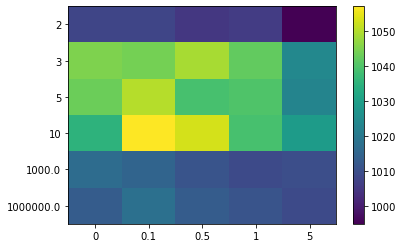

In [26]:
plt.imshow(counts_exp1, aspect='auto')
plt.yticks(range(len(iif_values)), iif_values)
plt.xticks(range(len(dp_values)), dp_values)
plt.colorbar()

## Experiment 2 - QCB, SmartROI

In [27]:
output_folder = 'experiment_2'

In [28]:
for iif in iif_values:
    for dp in dp_values:
        print(iif, dp)
        intensity_increase_factor = iif # fragment ROI again if intensity increases 10 fold
        drop_perc = dp/100


        # ROI can also be fragmented again if intensity falls to <1% of the max *since* last fragmentation
        from vimms.Controller import TopN_SmartRoiController
        controller = TopN_SmartRoiController(ionisation_mode, isolation_width, mz_tol, min_ms1_intensity,
                                             min_roi_intensity, min_roi_length, N=N, rt_tol=rt_tol, 
                                             min_roi_length_for_fragmentation=min_roi_length_for_fragmentation,
                                             reset_length_seconds=reset_length_seconds,
                                             intensity_increase_factor=intensity_increase_factor,
                                             drop_perc=drop_perc)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, SmartROI_QCB_dataset,
                                               scan_duration=roi_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        out_name = 'SmartROI_{}_{}.mzml'.format(iif,dp)
        env.write_mzML(output_folder, out_name)

2 0


  0%|          | 0/1560 [00:00<?, ?it/s]

2 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

2 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

2 1


  0%|          | 0/1560 [00:00<?, ?it/s]

2 5


  0%|          | 0/1560 [00:00<?, ?it/s]

3 0


  0%|          | 0/1560 [00:00<?, ?it/s]

3 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

3 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

3 1


  0%|          | 0/1560 [00:00<?, ?it/s]

3 5


  0%|          | 0/1560 [00:00<?, ?it/s]

5 0


  0%|          | 0/1560 [00:00<?, ?it/s]

5 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

5 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

5 1


  0%|          | 0/1560 [00:00<?, ?it/s]

5 5


  0%|          | 0/1560 [00:00<?, ?it/s]

10 0


  0%|          | 0/1560 [00:00<?, ?it/s]

10 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

10 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

10 1


  0%|          | 0/1560 [00:00<?, ?it/s]

10 5


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 0


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 1


  0%|          | 0/1560 [00:00<?, ?it/s]

1000.0 5


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 0


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 0.1


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 0.5


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 1


  0%|          | 0/1560 [00:00<?, ?it/s]

1000000.0 5


  0%|          | 0/1560 [00:00<?, ?it/s]

In [29]:
counts_exp2 = np.zeros((len(iif_values), len(dp_values)))
for i, iif in enumerate(iif_values):
    for j, dp in enumerate(dp_values):
        print(iif, dp)
        fname = 'SmartROI_{}_{}.mzml'.format(iif,dp)
        mz_file = MZMLFile(os.path.join(output_folder,fname))
        scans2boxes, boxes2scans = map_boxes_to_scans(mz_file, SmartROI_QCB_boxes, half_isolation_window=0)
        counts_exp2[i, j] = len(boxes2scans)
        
save_obj(counts_exp2, 'counts_exp2.p')

2 0
2 0.1
2 0.5
2 1
2 5
3 0
3 0.1
3 0.5
3 1
3 5
5 0
5 0.1
5 0.5
5 1
5 5
10 0
10 0.1
10 0.5
10 1
10 5
1000.0 0
1000.0 0.1
1000.0 0.5
1000.0 1
1000.0 5
1000000.0 0
1000000.0 0.1
1000000.0 0.5
1000000.0 1
1000000.0 5


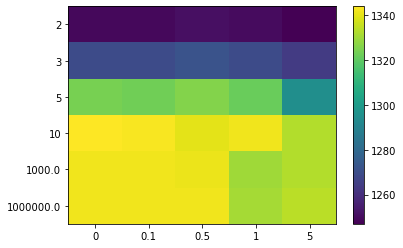

In [30]:
plt.imshow(counts_exp2, aspect='auto')
plt.yticks(range(len(iif_values)), iif_values)
plt.xticks(range(len(dp_values)), dp_values)
plt.colorbar()

## Experiment 3 - QCA, WeightedDEW

In [31]:
output_folder = 'experiment_3'

In [32]:
for t0 in t0_vals:
    for r in rt_tol_vals:
        if t0 > r:
            # impossible combination
            continue
        print(t0,r)
        out_name = 'WeightedDEW_{}_{}.mzml'.format(t0,r)

        if os.path.isfile(os.path.join(output_folder,out_name)):
            print("Already done")
            continue
        
        controller = WeightedDEWController(ionisation_mode, N, isolation_width, mz_tol, 
                                            r, min_ms1_intensity, exclusion_t_0=t0, log_intensity=True)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, WeightedDEW_QCA_dataset,
                                               scan_duration=topn_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        env.write_mzML(output_folder, out_name)

1 15


  0%|          | 0/1560 [00:00<?, ?it/s]

1 60


  0%|          | 0/1560 [00:00<?, ?it/s]

1 120


  0%|          | 0/1560 [00:00<?, ?it/s]

1 240


  0%|          | 0/1560 [00:00<?, ?it/s]

1 360


  0%|          | 0/1560 [00:00<?, ?it/s]

1 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

3 15


  0%|          | 0/1560 [00:00<?, ?it/s]

3 60


  0%|          | 0/1560 [00:00<?, ?it/s]

3 120


  0%|          | 0/1560 [00:00<?, ?it/s]

3 240


  0%|          | 0/1560 [00:00<?, ?it/s]

3 360


  0%|          | 0/1560 [00:00<?, ?it/s]

3 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

10 15


  0%|          | 0/1560 [00:00<?, ?it/s]

10 60


  0%|          | 0/1560 [00:00<?, ?it/s]

10 120


  0%|          | 0/1560 [00:00<?, ?it/s]

10 240


  0%|          | 0/1560 [00:00<?, ?it/s]

10 360


  0%|          | 0/1560 [00:00<?, ?it/s]

10 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

15 15


  0%|          | 0/1560 [00:00<?, ?it/s]

15 60


  0%|          | 0/1560 [00:00<?, ?it/s]

15 120


  0%|          | 0/1560 [00:00<?, ?it/s]

15 240


  0%|          | 0/1560 [00:00<?, ?it/s]

15 360


  0%|          | 0/1560 [00:00<?, ?it/s]

15 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

30 60


  0%|          | 0/1560 [00:00<?, ?it/s]

30 120


  0%|          | 0/1560 [00:00<?, ?it/s]

30 240


  0%|          | 0/1560 [00:00<?, ?it/s]

30 360


  0%|          | 0/1560 [00:00<?, ?it/s]

30 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

60 60


  0%|          | 0/1560 [00:00<?, ?it/s]

60 120


  0%|          | 0/1560 [00:00<?, ?it/s]

60 240


  0%|          | 0/1560 [00:00<?, ?it/s]

60 360


  0%|          | 0/1560 [00:00<?, ?it/s]

60 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

In [33]:
counts_exp3 = np.zeros((len(t0_vals), len(rt_tol_vals)))
for i, t0 in enumerate(t0_vals):
    for j, r in enumerate(rt_tol_vals):
        print(t0, r)
        if t0 > r:
            # impossible combination
            counts_exp3[i, j] = np.nan # fix for colour on boxplot
            continue
            
        fname = 'WeightedDEW_{}_{}.mzml'.format(t0,r)
        mz_file = MZMLFile(os.path.join(output_folder, fname))
        scans2boxes, boxes2scans = map_boxes_to_scans(mz_file, WeightedDEW_QCA_boxes, half_isolation_window=0)
        counts_exp3[i, j] = len(boxes2scans)
        
save_obj(counts_exp3, 'counts_exp3.p')

1 15
1 60
1 120
1 240
1 360
1 3600
3 15
3 60
3 120
3 240
3 360
3 3600
10 15
10 60
10 120
10 240
10 360
10 3600
15 15
15 60
15 120
15 240
15 360
15 3600
30 15
30 60
30 120
30 240
30 360
30 3600
60 15
60 60
60 120
60 240
60 360
60 3600


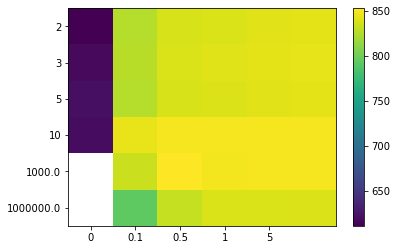

In [34]:
plt.imshow(counts_exp3, aspect='auto')
plt.yticks(range(len(iif_values)), iif_values)
plt.xticks(range(len(dp_values)), dp_values)
plt.colorbar()

## Experiment 4 - QCB, WeightedDEW

In [35]:
output_folder = 'experiment_4'

In [37]:
for t0 in t0_vals:
    for r in rt_tol_vals:
        if t0 > r:
            # impossible combination
            continue
        print(t0, r)
        out_name = 'WeightedDEW_{}_{}.mzml'.format(t0, r)

        if os.path.isfile(os.path.join(output_folder, out_name)):
            print("Already done")
            continue
        
        controller = WeightedDEWController(ionisation_mode, N, isolation_width, mz_tol, 
                                            r, min_ms1_intensity, exclusion_t_0=t0, log_intensity=True)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, WeightedDEW_QCB_dataset,
                                               scan_duration=topn_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        env.write_mzML(output_folder, out_name)

1 15


  0%|          | 0/1560 [00:00<?, ?it/s]

1 60


  0%|          | 0/1560 [00:00<?, ?it/s]

1 120


  0%|          | 0/1560 [00:00<?, ?it/s]

1 240


  0%|          | 0/1560 [00:00<?, ?it/s]

1 360


  0%|          | 0/1560 [00:00<?, ?it/s]

1 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

3 15


  0%|          | 0/1560 [00:00<?, ?it/s]

3 60


  0%|          | 0/1560 [00:00<?, ?it/s]

3 120


  0%|          | 0/1560 [00:00<?, ?it/s]

3 240


  0%|          | 0/1560 [00:00<?, ?it/s]

3 360


  0%|          | 0/1560 [00:00<?, ?it/s]

3 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

10 15


  0%|          | 0/1560 [00:00<?, ?it/s]

10 60


  0%|          | 0/1560 [00:00<?, ?it/s]

10 120


  0%|          | 0/1560 [00:00<?, ?it/s]

10 240


  0%|          | 0/1560 [00:00<?, ?it/s]

10 360


  0%|          | 0/1560 [00:00<?, ?it/s]

10 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

15 15


  0%|          | 0/1560 [00:00<?, ?it/s]

15 60


  0%|          | 0/1560 [00:00<?, ?it/s]

15 120


  0%|          | 0/1560 [00:00<?, ?it/s]

15 240


  0%|          | 0/1560 [00:00<?, ?it/s]

15 360


  0%|          | 0/1560 [00:00<?, ?it/s]

15 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

30 60


  0%|          | 0/1560 [00:00<?, ?it/s]

30 120


  0%|          | 0/1560 [00:00<?, ?it/s]

30 240


  0%|          | 0/1560 [00:00<?, ?it/s]

30 360


  0%|          | 0/1560 [00:00<?, ?it/s]

30 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

60 60


  0%|          | 0/1560 [00:00<?, ?it/s]

60 120


  0%|          | 0/1560 [00:00<?, ?it/s]

60 240


  0%|          | 0/1560 [00:00<?, ?it/s]

60 360


  0%|          | 0/1560 [00:00<?, ?it/s]

60 3600


  0%|          | 0/1560 [00:00<?, ?it/s]

In [38]:
counts_exp4 = np.zeros((len(t0_vals), len(rt_tol_vals)))
for i, t0 in enumerate(t0_vals):
    for j, r in enumerate(rt_tol_vals):
        print(t0,r)
        if t0 > r:
            # impossible combination
            counts_exp4[i, j] = np.nan # fix for colour on boxplot
            continue
            
        fname = 'WeightedDEW_{}_{}.mzml'.format(t0, r)
        mz_file = MZMLFile(os.path.join(output_folder, fname))
        scans2boxes, boxes2scans = map_boxes_to_scans(mz_file, WeightedDEW_QCB_boxes, half_isolation_window = 0)
        counts_exp4[i, j] = len(boxes2scans)
        
save_obj(counts_exp4, 'counts_exp4.p')

1 15
1 60
1 120
1 240
1 360
1 3600
3 15
3 60
3 120
3 240
3 360
3 3600
10 15
10 60
10 120
10 240
10 360
10 3600
15 15
15 60
15 120
15 240
15 360
15 3600
30 15
30 60
30 120
30 240
30 360
30 3600
60 15
60 60
60 120
60 240
60 360
60 3600


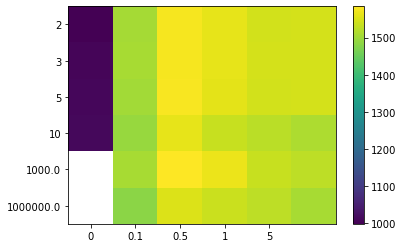

In [39]:
plt.imshow(counts_exp4, aspect='auto')
plt.yticks(range(len(iif_values)), iif_values)
plt.xticks(range(len(dp_values)), dp_values)
plt.colorbar()